In [ ]:
import re
import random

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving placementdata.csv to placementdata.csv
User uploaded file "placementdata.csv" with length 447296 bytes


In [29]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('placementdata.csv')

In [30]:
dataset.head()

,StudentID,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
0,1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
1,2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
2,3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
3,4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
4,5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


Logistic ML Algorithm

In [31]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [36]:
feature_cols = ['CGPA', 'Internships', 'Projects', 'Workshops/Certifications', 'AptitudeTestScore',
               'SoftSkillsRating', 'ExtracurricularActivities','PlacementTraining',
               'SSC_Marks', 'HSC_Marks']

X, y = dataset[feature_cols], dataset.PlacementStatus

# Apply one-hot encoding to categorical columns
X = pd.get_dummies(X, columns=['ExtracurricularActivities', 'PlacementTraining'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

# Scale the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
logreg = LogisticRegression(random_state=16)

logreg.fit(X_train, y_train)

y_predict = logreg.predict(X_test)

In [38]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_predict)
cnf_matrix

array([[1227,  236],
       [ 259,  778]])

Text(0.5, 427.9555555555555, 'Predicted label')

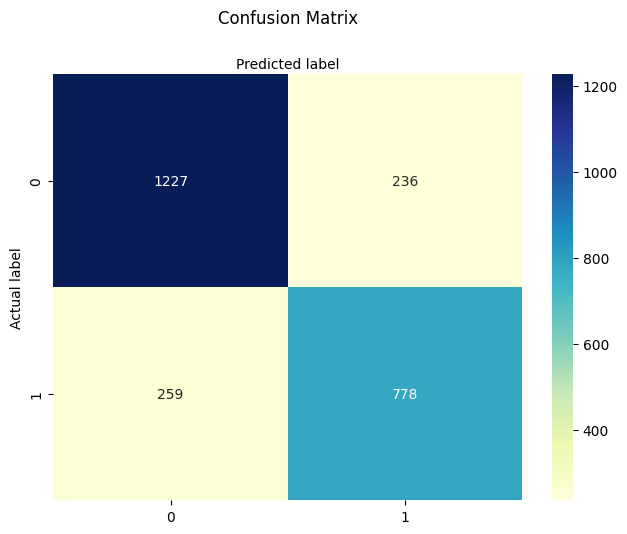

In [41]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu', fmt='g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [42]:
target_names = ['Placement', 'No Placement']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

   Placement       0.83      0.84      0.83      1463
No Placement       0.77      0.75      0.76      1037

    accuracy                           0.80      2500
   macro avg       0.80      0.79      0.80      2500
weighted avg       0.80      0.80      0.80      2500



Random Forest ML Algorithm

In [52]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [55]:
import pandas as pd

dataset = pd.read_csv('placementdata.csv') # Re-load the dataset

dataset['ExtracurricularActivities'] = dataset['ExtracurricularActivities'].map({'Yes': 1, 'No': 0})
dataset['PlacementTraining'] = dataset['PlacementTraining'].map({'Yes': 1, 'No': 0})
dataset['PlacementStatus'] = dataset['PlacementStatus'].map({'Placed': 1, 'NotPlaced': 0}) # Corrected mapping

# Drop rows with NaN in the target variable
#dataset.dropna(subset=['PlacementStatus'], inplace=True)


X = dataset.drop(['PlacementStatus'], axis=1)
y = dataset['PlacementStatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [57]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7925


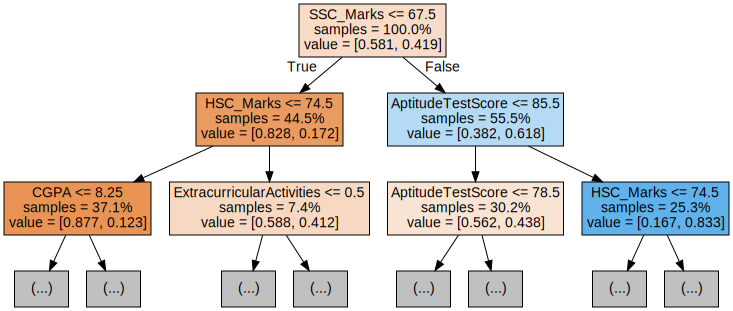

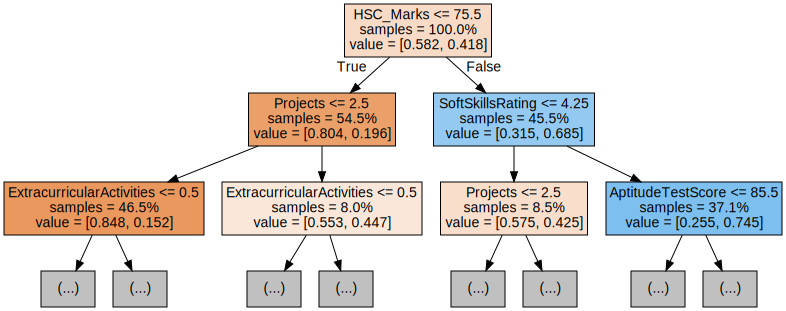

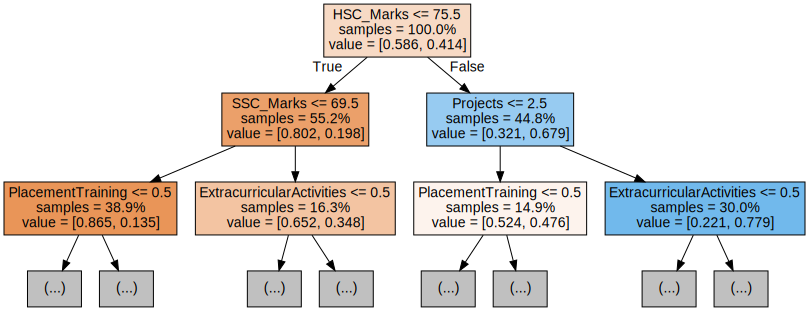

In [58]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [60]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e0db6c70750>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e0db6c70110>})

In [61]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 5, 'n_estimators': 71}


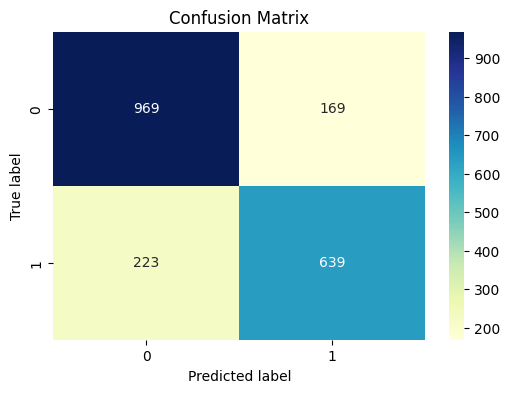

In [69]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Use seaborn to plot the heatmap with the 'YlGnBu' colormap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu', cbar=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [67]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.804
Precision: 0.7908415841584159
Recall: 0.7412993039443155


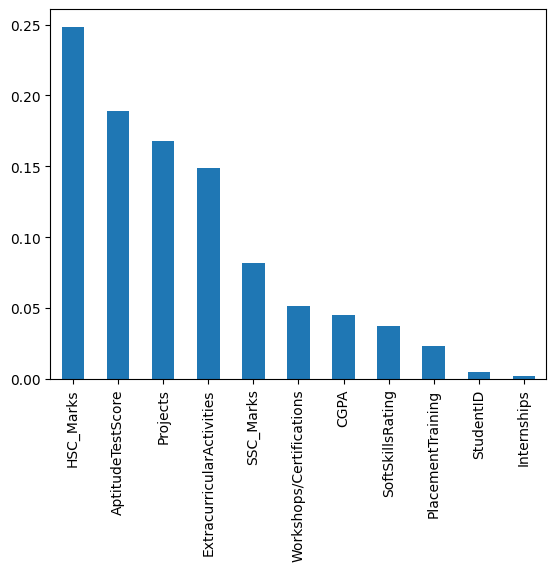

In [68]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

In [ ]:
# https://www.datacamp.com/tutorial/random-forests-classifier-python

Simple K Means Algorithm

Naive Bayes Algorithm